* By: Aaron Debrincat, Franklin Willaims, Hansen Pei, Joel Ong, Yefang Wang
* Email: aaron.deb.31@gmail.com, streater@uw.edu, hansenp@udel.edu, ong.joel.94@gmail.com, stoch_adv@protonmail.com
* Reference: __Enhancing a Pairs Trading strategy with the application of Machine Learning__ _by_ Simão Moraes Sarmento and Nuno Horta



# Implementation of a Machine Learning based Pairs Selection Framework

## Abstract

In this paper[1], Horta and Sarmento propose a two stage solution to applying machine learning to the problem of pairs trading. The first stage involves the application of a clustering algorithm to infer any meaningful clusters and using these groups to generate pairs that will be run through a selection process that will supply a list of pairs that comply with the conditions set. 

The second stage should start by training forecasting algorithms to predict the spreads of the selected pairs. Further more, decile-based and quintile-based thresholds should be collected to integrate the trading model. Having fitted the forecasting algorithms and obtained the two combinations for the thresholds, the model can be applied on the validation set. From the validation performance, the best threshold combination is selected. At this point, the model is finally ready to be applied on unseen data, from which the performance may be inferred.

## Introduction

This notebook will focus on the first stage, which refers to the pairs selection methodology. It will involve the application of PCA to distill the returns universe into a lower dimensional form. Then the OPTICS algorithm will be applied, on the expectation that it infers meaningful clusters of assets from which to select the pairs. The motivation is to let the data explicitly manifest itself, rather than manually defining the groups each security should belong to. The proposed methodology encompasses the following steps:

- Dimensionality reduction - find a compact representation for each security;
- Unsupervised Learning - apply an appropriate clustering algorithm;
- Select pairs - define a set of rules to select pairs for trading.


![image info](./images/prposed_framework_diagram.png)

---

# Example Usage of Implementation

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import pandas as pd
import arbitragelab as al

import warnings
warnings.filterwarnings('ignore')

In [4]:
P_i = pd.read_csv('./data/data.csv').set_index('Date').dropna()
P_i.index = pd.to_datetime(P_i.index)

P_i = P_i.last('10Y')

P_i.sample(10)

A        AAL         AAP        AAPL       ABBV  \
Date                                                                  
2019-03-14  80.610001  32.130001  154.000000   45.932499  79.949997   
2018-08-17  64.660004  37.790001  159.720001   54.395000  98.809998   
2018-11-20  67.519997  35.590000  171.529999   44.244999  88.089996   
2016-06-10  45.360001  33.139999  153.020004   24.707500  61.000000   
2016-03-04  39.340000  41.630001  152.369995   25.752501  56.150002   
2019-09-06  74.279999  27.790001  147.210007   53.314999  67.620003   
2016-06-02  45.900002  31.670000  152.149994   24.430000  65.089996   
2016-01-28  36.110001  38.139999  148.559998   23.522499  55.849998   
2020-09-03  99.639999  13.360000  155.179993  120.879997  91.870003   
2016-05-31  45.889999  31.910000  153.839996   24.965000  62.930000   

                  ABC        ABMD         ABT         ACN        ADBE  ...  \
Date                                                                   ...   
2019-03-14  79.510002  325.609985   78.980003  164.820007  267.690002  ...   
2018-08-17  87.720001  358.820007   64.720001  164.889999  245.699997  ...   
2018-11-20  88.870003  302.290009   69.059998  158.899994  219.729996  ...   
2016-06-10  76.459999  102.529999   38.400002  118.269997   97.089996  ...   
2016-03-04  88.000000   84.000000   39.180000  103.180000   86.180000  ...   
2019-09-06  86.320000  189.429993   86.040001  201.119995  284.940002  ...   
2016-06-02  77.080002  101.870003   39.529999  119.239998  100.169998  ...   
2016-01-28  87.290001   81.769997   36.709999  103.080002   84.519997  ...   
2020-09-03  97.580002  294.010010  105.529999  238.979996  507.799988  ...   
2016-05-31  74.980003   99.309998   39.630001  118.970001   99.470001  ...   

                  XLNX        XOM       XRAY        XRX        XYL  \
Date                                                                 
2019-03-14  122.480003  80.440002  49.189999  31.080000  76.500000   
2018-08-17   71.019997  78.260002  38.669998  26.940001  75.430000   
2018-11-20   84.680000  76.970001  36.919998  25.290001  67.220001   
2016-06-10   46.730000  89.980003  63.610001  26.166008  45.919998   
2016-03-04   47.000000  82.290001  60.160000  27.667984  38.220001   
2019-09-06  105.940002  70.930000  50.689999  29.850000  78.389999   
2016-06-02   47.119999  88.529999  63.000000  26.719368  45.209999   
2016-01-28   48.000000  76.989998  58.130001  24.321476  34.950001   
2020-09-03  103.099998  39.110001  44.560001  18.370001  81.660004   
2016-05-31   47.389999  89.019997  62.160000  26.271410  44.660000   

                   YUM         ZBH        ZBRA       ZION         ZTS  
Date                                                                   
2019-03-14   98.980003  122.940002  212.669998  49.080002   96.199997  
2018-08-17   83.809998  123.860001  163.570007  53.730000   91.470001  
2018-11-20   87.190002  112.400002  162.289993  47.380001   88.410004  
2016-06-10   59.309849  119.230003   56.020000  27.990000   47.389999  
2016-03-04   56.110710   99.290001   65.410004  24.340000   40.799999  
2019-09-06  119.209999  139.740005  202.729996  40.939999  128.429993  
2016-06-02   59.281094  122.910004   54.310001  28.670000   48.130001  
2016-01-28   50.618259   97.550003   55.700001  22.150000   42.840000  
2020-09-03   96.330002  140.520004  269.250000  32.490002  158.800003  
2016-05-31   59.015099  122.110001   53.110001  28.020000   47.419998  

[10 rows x 491 columns]

## Step 1 - Dimensionality Reduction

### Using PCA to find a compact representation for each security

- Extracts common underlying risk factors from securities’ returns;
- Produces a compact representation for each security;

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f948dd36ef0>,
      dtype=object)

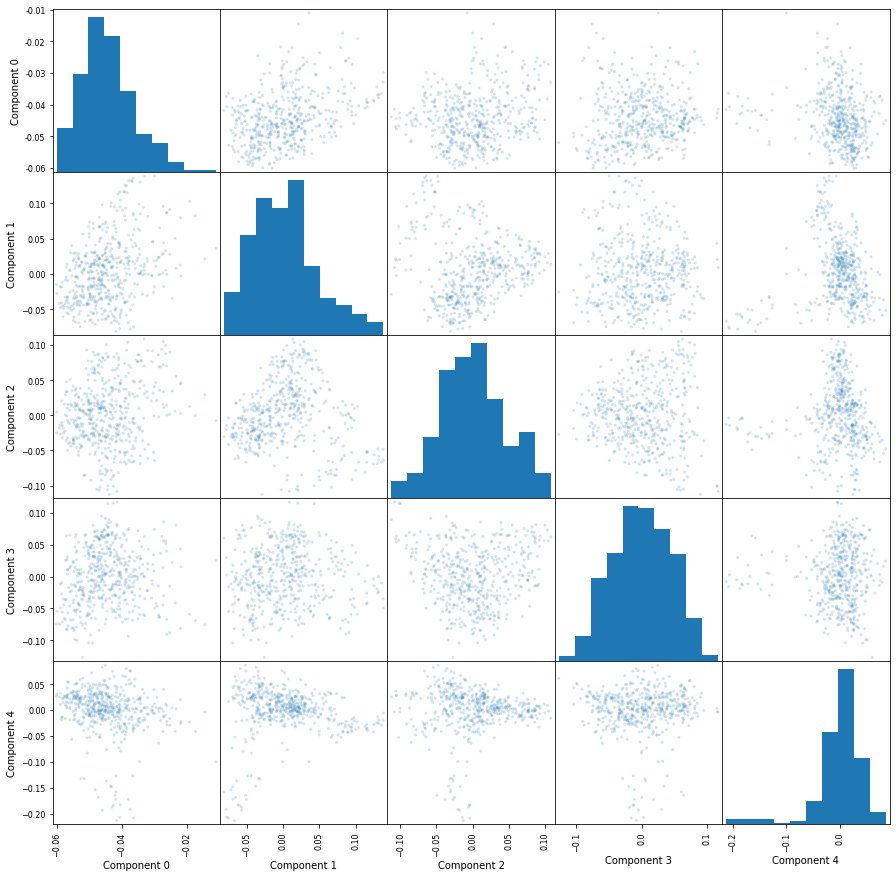

In [5]:
ps = al.ml_approach.PairsSelector(P_i)
ps.dimensionality_reduction_by_components(5)
ps.plot_pca_matrix()

## Step 2 - Unsupervised Learning
### Applying OPTICS clustering algorithm

- No need to specify the number of clusters in advance;
- Robust to outliers;
- Suitable for clusters with varying density

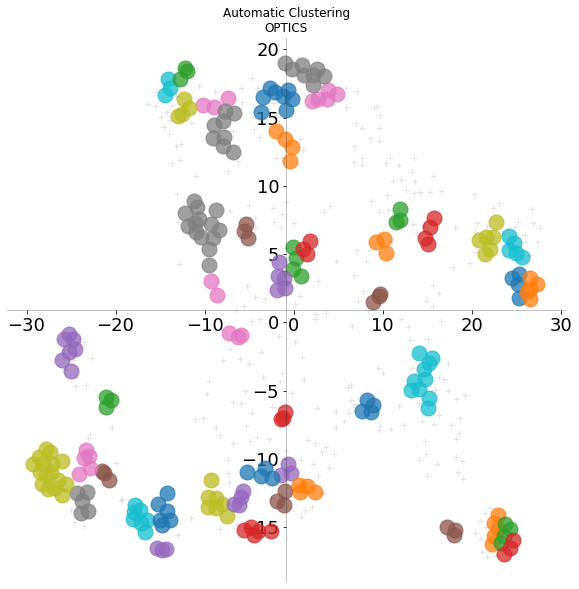

In [6]:
%matplotlib inline

ps.cluster_using_optics({'min_samples': 3})
ps.plot_clustering_info(method='OPTICS')

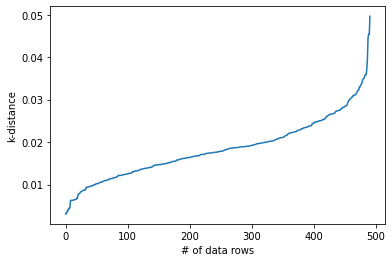

In [10]:
%matplotlib inline

ps.plot_knee_plot()

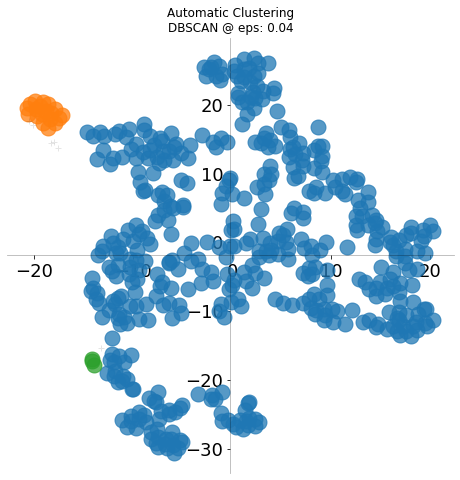

----------------------------------------------------------------------------------------------------


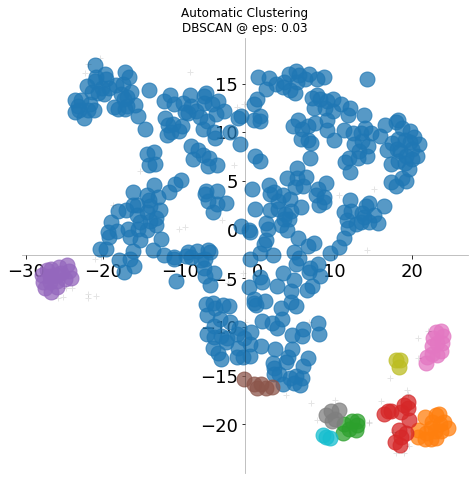

----------------------------------------------------------------------------------------------------


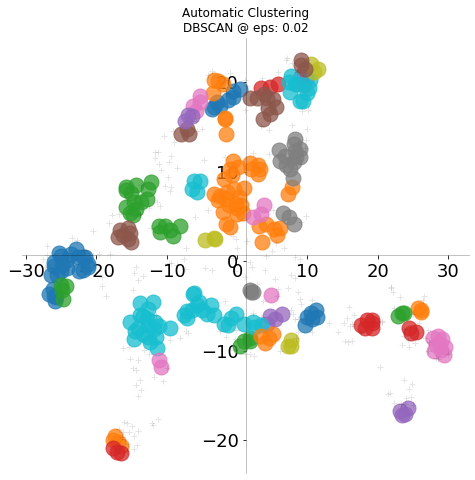

In [11]:
%matplotlib inline

ps.cluster_using_dbscan({'eps': 0.04, 'min_samples': 3, 'metric':'euclidean'})
ps.plot_clustering_info(method='DBSCAN @ eps: 0.04', figsize=(8,8))

print('-' * 100)

ps.cluster_using_dbscan({'eps': 0.03, 'min_samples': 3, 'metric':'euclidean'})
ps.plot_clustering_info(method='DBSCAN @ eps: 0.03', figsize=(8,8))

print('-' * 100)

ps.cluster_using_dbscan({'eps': 0.02, 'min_samples': 3, 'metric':'euclidean'})
ps.plot_clustering_info(method='DBSCAN @ eps: 0.02', figsize=(8,8))

## Step 3 - Select Pairs
### Finding resulting pairs that pass the following set of rules

- Cointegrated pairs - Finds sound equilibrium relationships;
- Mean-reverting Hurst exponent - Provides an extra layer of confidence to validate mean-reverting series;
- Suitable half-life - Filters out series with timings not compatible with the trading period;
- Monthly mean crossing - Filters out pairs for which the spread does not converge to its mean with enough regularity

In [7]:
ps.unsupervised_candidate_pair_selector()

array([('AJG', 'ICE'), ('AJG', 'MMC'), ('ICE', 'MMC'), ('MMC', 'WLTW'),
       ('EW', 'FISV'), ('IQV', 'V'), ('NVR', 'PHM'), ('HPE', 'NWS'),
       ('HPE', 'NWSA'), ('NSC', 'UNP'), ('NWS', 'NWSA'), ('AMAT', 'MCHP'),
       ('ATVI', 'EA'), ('AKAM', 'CTXS'), ('CFG', 'FITB'), ('CFG', 'KEY'),
       ('CCI', 'DLR'), ('AWK', 'XEL'), ('ES', 'WEC'), ('FRT', 'REG'),
       ('SLG', 'VNO'), ('APA', 'SLB'), ('EOG', 'MRO')], dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f947c49d198>,
      dtype=object)

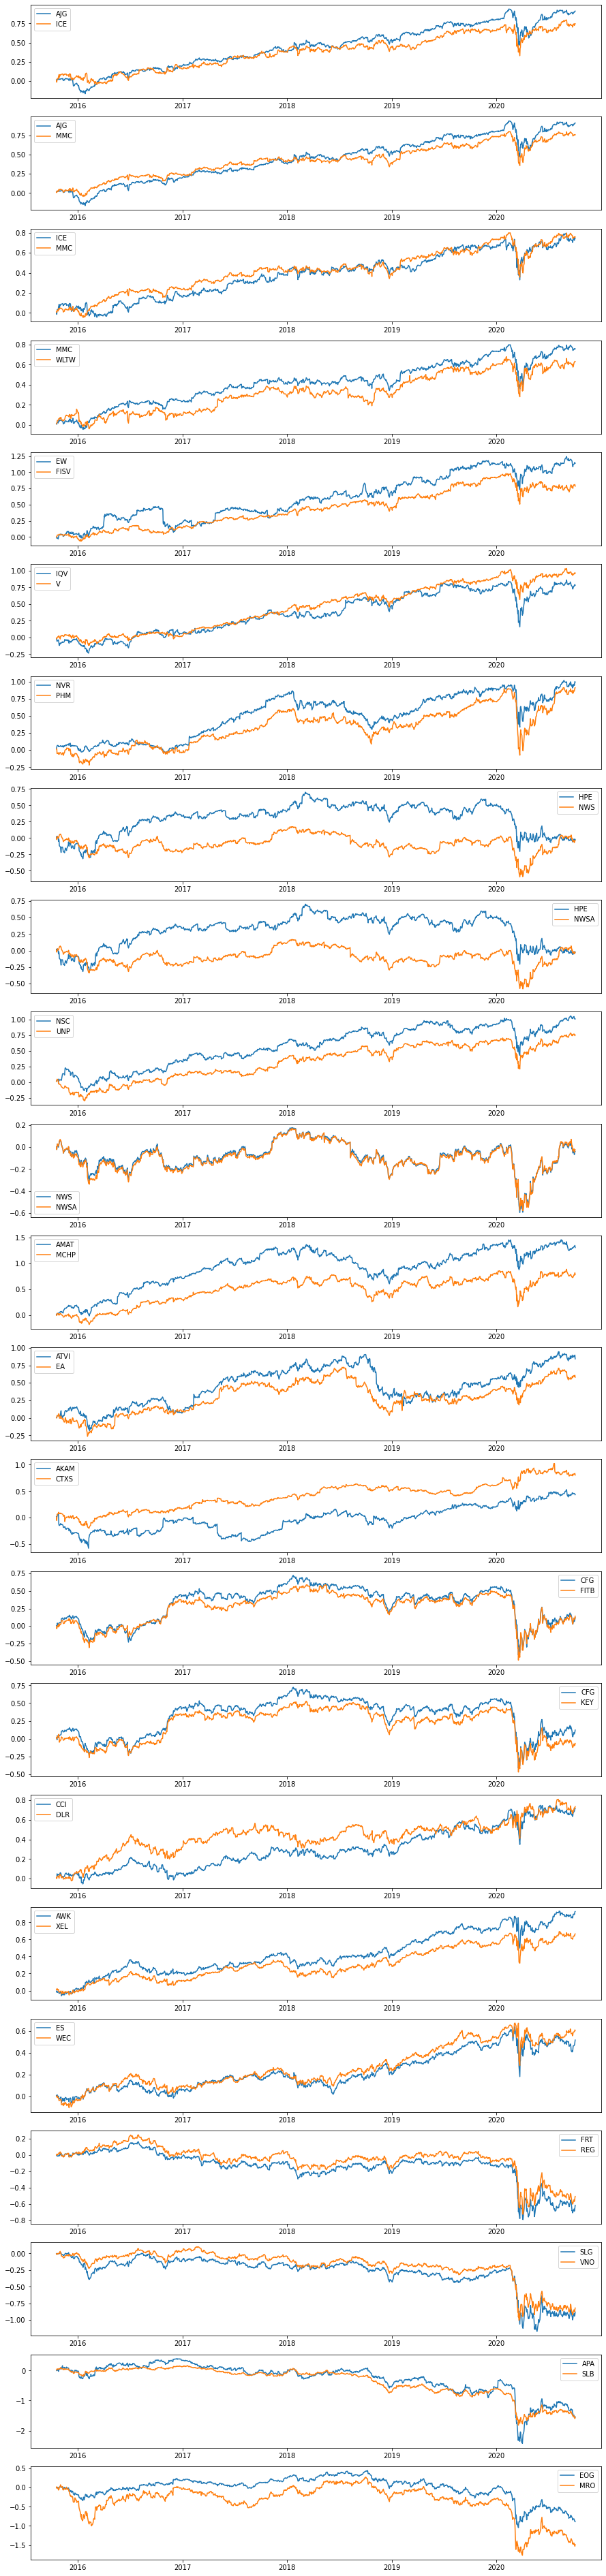

In [8]:
ps.plot_selected_pairs()

In [9]:
ps.describe_extra()

leg_1 leg_2   coint_t    pvalue  hedge_ratio  hurst_exponent   half_life  \
0    AJG   ICE -5.147984  0.000011     0.832406        0.280300    1.178147   
1    AJG   MMC -3.984768  0.001492     0.892408        0.333155    1.325405   
2    ICE   MMC -4.314326  0.000420     1.072514        0.353929    3.312397   
3    MMC  WLTW -4.173535  0.000730     1.758648        0.330393    2.353220   
4   CHTR  TMUS -3.834987  0.002569     0.166618        0.350558    2.954012   
5     EW  FISV -3.775258  0.003171     1.247778        0.342441    1.774284   
6     EW   GPN -4.614576  0.000121     2.381694        0.388706   10.865253   
7   FISV   GPN -3.788320  0.003029     1.890617        0.366615    1.021983   
8    IQV     V -3.432286  0.009906     1.353333        0.331590    1.975149   
9    NVR   PHM -3.553403  0.006717     0.009508        0.389903   13.683387   
10    DE  NWSA -3.436995  0.009761     0.014579        0.451436    5.102561   
11   FDX   NWS -4.413967  0.000280     0.028715        0.427401    4.389517   
12   FDX  NWSA -4.557553  0.000155     0.028714        0.429314    4.521595   
13   HPE   NWS -3.834902  0.002570     0.363664        0.465219    6.372941   
14   HPE  NWSA -3.874811  0.002228     0.357653        0.469496    6.801983   
15   NSC   UNP -4.660216  0.000100     0.838381        0.324220    1.451063   
16   NWS  NWSA -4.168106  0.000746     0.996404        0.196929   36.025740   
17  AMAT  MCHP -4.266025  0.000508     1.389705        0.304179    1.339289   
18  LRCX  QRVO -3.663744  0.004653     0.255194        0.338930    1.058724   
19  ATVI    EA -3.843478  0.002493     1.516788        0.452648    1.807497   
20  AKAM  CTXS -3.452623  0.009291     1.429438        0.440121    6.690855   
21   CFG  FITB -4.159279  0.000772     0.671913        0.342228    6.753700   
22   CFG   KEY -4.002581  0.001397     0.453079        0.350015   14.697026   
23   CCI   DLR -3.433393  0.009872     0.693800        0.373557    1.219022   
24   AWK   XEL -3.583313  0.006088     0.411916        0.254237    1.604094   
25   CMS   LNT -4.050546  0.001168     0.792577        0.288188    5.088663   
26    ES   WEC -4.072051  0.001077     1.198148        0.280246    2.441315   
27   ESS   UDR -3.508588  0.007769     0.136507        0.338250    4.290441   
28   FRT   REG -3.716566  0.003886     0.458946        0.358631    3.811393   
29   SLG   VNO -3.723620  0.003793     0.707037        0.409197    7.565509   
30   APA   SLB -3.690962  0.004242     1.471069        0.369010  178.557381   
31   EOG   MRO -4.172821  0.000732     0.196746        0.348182    8.144013   

   crossovers  
0        True  
1        True  
2        True  
3        True  
4       False  
5        True  
6       False  
7       False  
8        True  
9        True  
10      False  
11      False  
12      False  
13       True  
14       True  
15       True  
16       True  
17       True  
18      False  
19       True  
20       True  
21       True  
22       True  
23       True  
24       True  
25      False  
26       True  
27      False  
28       True  
29       True  
30       True  
31       True

In [10]:
ps.describe()

0    1
0                    No. of Clusters   46
1            Total Pair Combinations  631
2           Pairs passing Coint Test   53
3      Pairs passing Hurst threshold   53
4  Pairs passing Half Life threshold   32
5                 Final Set of Pairs   23

## Analysis of selected pairs sector/industry classifications


In [14]:
sectoral_info = pd.read_csv('./data/sp500_ticker_sector_info.csv').drop('Unnamed: 0', axis=1)

final_pairs_info = ps.describe_extra()

ps.describe_pairs_sectoral_info(final_pairs_info['leg_1'], final_pairs_info['leg_2'], sectoral_info)

Leg 1 Ticker                             Industry                  Sector  \
0           AJG                    Insurance Brokers      Financial Services   
1           AJG                    Insurance Brokers      Financial Services   
2           ICE     Financial Data & Stock Exchanges      Financial Services   
3           MMC                    Insurance Brokers      Financial Services   
4          CHTR                        Entertainment  Communication Services   
5            EW                      Medical Devices              Healthcare   
6            EW                      Medical Devices              Healthcare   
7          FISV      Information Technology Services              Technology   
8           IQV               Diagnostics & Research              Healthcare   
9           NVR             Residential Construction       Consumer Cyclical   
10           DE  Farm & Heavy Construction Machinery             Industrials   
11          FDX       Integrated Freight & Logistics             Industrials   
12          FDX       Integrated Freight & Logistics             Industrials   
13          HPE              Communication Equipment              Technology   
14          HPE              Communication Equipment              Technology   
15          NSC                            Railroads             Industrials   
16          NWS                         Broadcasting  Communication Services   
17         AMAT  Semiconductor Equipment & Materials              Technology   
18         LRCX  Semiconductor Equipment & Materials              Technology   
19         ATVI       Electronic Gaming & Multimedia  Communication Services   
20         AKAM              Software—Infrastructure              Technology   
21          CFG                       Banks—Regional      Financial Services   
22          CFG                       Banks—Regional      Financial Services   
23          CCI                       REIT—Specialty             Real Estate   
24          AWK            Utilities—Regulated Water               Utilities   
25          CMS         Utilities—Regulated Electric               Utilities   
26           ES         Utilities—Regulated Electric               Utilities   
27          ESS                     REIT—Residential             Real Estate   
28          FRT                          REIT—Retail             Real Estate   
29          SLG                          REIT—Office             Real Estate   
30          APA                        Oil & Gas E&P                  Energy   
31          EOG                        Oil & Gas E&P                  Energy   

   Leg 2 Ticker                          Industry                  Sector  
0           ICE  Financial Data & Stock Exchanges      Financial Services  
1           MMC                 Insurance Brokers      Financial Services  
2           MMC                 Insurance Brokers      Financial Services  
3          WLTW                 Insurance Brokers      Financial Services  
4          TMUS                  Telecom Services  Communication Services  
5          FISV   Information Technology Services              Technology  
6           GPN       Specialty Business Services             Industrials  
7           GPN       Specialty Business Services             Industrials  
8             V                   Credit Services      Financial Services  
9           PHM          Residential Construction       Consumer Cyclical  
10         NWSA                      Broadcasting  Communication Services  
11          NWS                      Broadcasting  Communication Services  
12         NWSA                      Broadcasting  Communication Services  
13          NWS                      Broadcasting  Communication Services  
14         NWSA                      Broadcasting  Communication Services  
15          UNP                         Railroads             Industrials  
16         NWSA                      Broadcasting  Communication Servi

# Clustering based on sector

In [15]:
pair_combinations = ps.get_pairs_by_sector(sectoral_info)

ps.manual_candidate_pair_selector(pair_combinations)

2020-11-05 13:00:42.994060 100.0% _outer_cointegration_loop done after 34.81 minutes. Remaining 0.0 minutes...
2020-11-05 13:00:57.487802 100.0% _outer_ou_loop_light done after 0.13 minutes. Remaining 0.0 minutes.
/home/aaron/Apprenticeship/mlfinlab_premium/mlfinlab/statistical_arbitrage/pairs_selector.py:307: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/aaron/Apprenticeship/mlfinlab_premium/mlfinlab/statistical_arbitrage/pairs_selector.py:311: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



array([('A', 'VAR'), ('AAPL', 'AMD'), ('ABT', 'HOLX'), ('ABT', 'ZTS'),
       ('ACN', 'AKAM'), ('ACN', 'FIS'), ('ACN', 'ORCL'), ('ACN', 'TXN'),
       ('ADI', 'AVGO'), ('ADI', 'FIS'), ('AEP', 'SRE'), ('AIZ', 'WU'),
       ('AJG', 'ICE'), ('AJG', 'MMC'), ('AKAM', 'CTXS'), ('ALL', 'AXP'),
       ('AMAT', 'MCHP'), ('AMD', 'JNPR'), ('AME', 'IEX'), ('AMT', 'PLD'),
       ('AMZN', 'KMX'), ('AMZN', 'UA'), ('ANET', 'FLIR'),
       ('ANSS', 'KLAC'), ('APA', 'SLB'), ('APH', 'MXIM'), ('APH', 'ORCL'),
       ('ATVI', 'EA'), ('AVGO', 'MCHP'), ('AVY', 'LMT'), ('AVY', 'NOC'),
       ('AWK', 'XEL'), ('BAC', 'CBOE'), ('BBY', 'ROL'), ('BKNG', 'PKG'),
       ('BKR', 'WMB'), ('BLL', 'KMX'), ('BMY', 'GILD'), ('BR', 'MXIM'),
       ('BSX', 'HCA'), ('CAT', 'EMR'), ('CB', 'HIG'), ('CBOE', 'JPM'),
       ('CBOE', 'RJF'), ('CCI', 'DLR'), ('CE', 'CF'), ('CERN', 'JNJ'),
       ('CFG', 'COF'), ('CFG', 'FITB'), ('CFG', 'MET'), ('CHD', 'MDLZ'),
       ('CHD', 'MKC'), ('CMG', 'F'), ('CMG', 'GPS'), ('CMI', 'PCAR'),
  

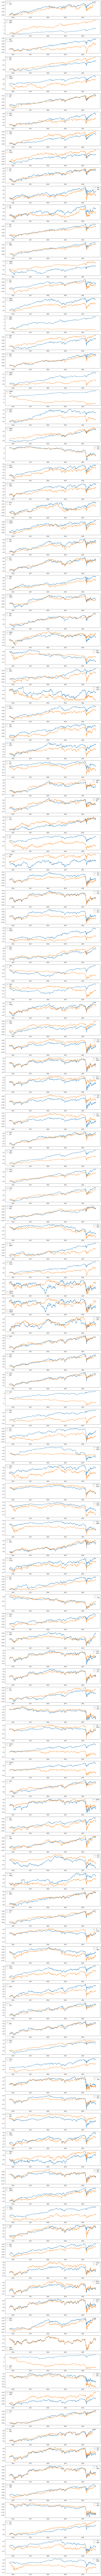

In [18]:
ps.plot_selected_pairs()

In [17]:
ps.describe_extra()

leg_1 leg_2   coint_t    pvalue  hedge_ratio  hurst_exponent  half_life  \
0     AJG   ICE -5.147984  0.000011     0.832406        0.280300   1.178147   
1     ABT   STE -4.754956  0.000066     1.722873        0.279465   7.253249   
2    NTRS   RJF -4.702088  0.000083     1.074065        0.269738   1.242156   
3     NSC   UNP -4.660216  0.000100     0.838381        0.324220   1.451063   
4    NTRS    RF -4.616117  0.000121     0.243353        0.253712   2.460114   
..    ...   ...       ...       ...          ...             ...        ...   
220  CDNS  SNPS -3.437534  0.009744     1.850566        0.361894   4.066255   
221   COO   SYK -3.437090  0.009758     0.604251        0.417449   2.168597   
222   DOV    TT -3.436882  0.009764     1.026698        0.396234   7.861226   
223   CCI   DLR -3.433393  0.009872     0.693800        0.373557   1.219022   
224  CTAS   DOV -3.430608  0.009959     0.277556        0.405339   1.190377   

    crossovers  
0         True  
1        False  
2        False  
3         True  
4         True  
..         ...  
220      False  
221       True  
222      False  
223       True  
224       True  

[225 rows x 8 columns]

In [22]:
final_pairs_info = ps.describe_extra()

ps.describe_pairs_sectoral_info(final_pairs_info['leg_1'], final_pairs_info['leg_2'], sectoral_info)

Leg 1 Ticker                        Industry              Sector  \
0            AJG               Insurance Brokers  Financial Services   
1            ABT                 Medical Devices          Healthcare   
2           NTRS                Asset Management  Financial Services   
3            NSC                       Railroads         Industrials   
4           NTRS                Asset Management  Financial Services   
..           ...                             ...                 ...   
220         CDNS            Software—Application          Technology   
221          COO  Medical Instruments & Supplies          Healthcare   
222          DOV  Specialty Industrial Machinery         Industrials   
223          CCI                  REIT—Specialty         Real Estate   
224         CTAS     Specialty Business Services         Industrials   

    Leg 2 Ticker                          Industry              Sector  
0            ICE  Financial Data & Stock Exchanges  Financial Services  
1            STE    Medical Instruments & Supplies          Healthcare  
2            RJF                   Capital Markets  Financial Services  
3            UNP                         Railroads         Industrials  
4             RF                    Banks—Regional  Financial Services  
..           ...                               ...                 ...  
220         SNPS           Software—Infrastructure          Technology  
221          SYK                   Medical Devices          Healthcare  
222           TT    Specialty Industrial Machinery         Industrials  
223          DLR                       REIT—Office         Real Estate  
224          DOV    Specialty Industrial Machinery         Industrials  

[225 rows x 6 columns]

---

# Conclusion

This notebook describes the proposed Pairs Selection Framework also shows example usage of the implemented framework.

The major takeaway from the notebook is that, most of the final pairs selected follow expected economic sectoral clusters even though there was no implied industry/sectoral grouping anywhere in the framework.

# References
1. Sarmento, Simão. & Horta, Nuno. (2020). Enhancing a Pairs Trading strategy with the application of Machine Learning. Available at: http://premio-vidigal.inesc.pt/pdf/SimaoSarmentoMSc-resumo.pdf